# Segmentace energetické chudoby

**LCA odhadnuto v LatentGOLD**
- zde jen načti a zobraz výsledky, abych byl schopen je porovnat

## Imports and functions

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [2]:
from yattag import Doc, indent
from datetime import datetime
import unicodedata

def slugify(value, allow_unicode=False):
    """
    Convert to ASCII if 'allow_unicode' is False. Convert spaces to hyphens.
    Remove characters that aren't alphanumerics, underscores, or hyphens.
    Convert to lowercase. Also strip leading and trailing whitespace.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value).strip().lower()
    return re.sub(r'[-\s]+', '-', value)


def create_stamped_temp(dir=None):
    stamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    if dir is None:
        path = '{}/{}'.format(os.environ['TEMP'], stamp)
    else:
        path = '{}/{}/{}'.format(os.environ['TEMP'], dir, stamp)
    os.makedirs(path, exist_ok=True)
    return path


class Chart:

    def __init__(self, figs, cols=3, title=None, format='png'):
        if not isinstance(figs, list):
            figs = [figs]
        self.figs = [f if isinstance(f, plt.Figure) else f.get_figure() for f in figs]
        self.cols = cols
        self.format = format
        self.title = title or self.figs[0].axes[0].title._text

    def save(self, path, inner=False):
        os.makedirs(path, exist_ok=True)
        n = len(self.figs)
        for i in range(n):
            self.figs[i].savefig(f'{path}/fig_{i+1:03d}.{self.format}')
        plt.close('all')

        doc, tag, text = Doc().tagtext()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Chart')
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Chart')
                num_rows = (n + self.cols - 1) // self.cols
                for r in range(num_rows):
                    with tag('div'):
                        for c in range(min(self.cols, n - self.cols * r)):
                            doc.stag('img', src=f'fig_{self.cols * r + c + 1:03d}.{self.format}')

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


class Text:

    def __init__(self, texts, width=750, title=None):
        if not isinstance(texts, list):
            texts = [texts]
        self.texts = texts
        self.width = width
        self.title = title

    def save(self, path, inner=False):
        os.makedirs(path, exist_ok=True)

        doc, tag, text = Doc().tagtext()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Text')
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Text')
                with tag('div'):
                    for t in self.texts:
                        with tag('div', style='width: {}px; float: left'.format(self.width)):
                            with tag('pre'):
                                text(t)

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


class Selector:

    def __init__(self, charts, title=None):
        if not isinstance(charts, list):
            charts = [charts]
        self.charts = [ch if isinstance(ch, (Text, Chart, Selector)) else Chart(ch) for ch in charts]
        self.title = title or 'Selector'

    def save(self, path):
        os.makedirs(path, exist_ok=True)
        n = len(self.charts)
        for i in range(n):
            ch = self.charts[i]
            if ch.title is None:
                ch.title = '{}_{:02d}'.format('Chart' if isinstance(ch, Chart) else ('Text' if isinstance(ch, Text)
                    else 'Selector'), i)
            ch.save('{}/{}'.format(path, slugify(ch.title)))

        doc, tag, text, line = Doc().ttl()

        doc.asis('<!DOCTYPE html>')
        with tag('html'):
            with tag('head'):
                with tag('title'):
                    text(self.title or 'Selector')
                with tag('script'):
                    doc.asis("""
      function loader(target, file) {
        var element = document.getElementById(target);
        var xmlhttp = new XMLHttpRequest();
        xmlhttp.onreadystatechange = function(){
          if(xmlhttp.status == 200 && xmlhttp.readyState == 4){          
            var txt = xmlhttp.responseText;
            var next_file = ""
            var matches = txt.match(/<script>loader\\('.*', '(.*)'\\)<\\/script>/);
            if (matches) {
              next_file = matches[1];
            };            
            txt = txt.replace(/^[\s\S]*<body>/, "").replace(/<\/body>[\s\S]*$/, "");
            txt = txt.replace(/src=\\"fig_/g, "src=\\"" + file + "/fig_");
            txt = txt.replace(/loader\\('/g, "loader('" + file.replace(/\\//g, "-") + "-");
            txt = txt.replace(/div id=\\"/, "div id=\\"" + file.replace(/\\//g, "-") + "-");
            txt = txt.replace(/content', '/g, "content', '" + file + "/");
            element.innerHTML = txt;
            if (next_file) {
              loader(file.replace(/\\//g, "-") + "-content", file + "/" + next_file);
            };            
          };
        };
        xmlhttp.open("GET", file + "/page.htm", true);
        xmlhttp.send();
      }
    """)
            with tag('body'):
                with tag('h1'):
                    text(self.title or 'Selector')
                with tag('div'):
                    for ch in self.charts:
                        #line('a', ch.title, href='{}/page.html'.format(slugify(ch.title)), target='iframe')
                        line('button', ch.title, type='button',
                             onclick='loader(\'content\', \'{}\')'.format(slugify(ch.title)))
                with tag('div', id='content'):
                    text('')
                with tag('script'):
                    doc.asis('loader(\'content\', \'{}\')'.format(slugify(self.charts[0].title)))

        file = open('{}/page.htm'.format(path), 'w', encoding='utf-8')
        file.write(indent(doc.getvalue()))
        file.close()

    def show(self):
        path = create_stamped_temp('reports')
        self.save(path)
        os.startfile('{}/page.htm'.format(path))


In [3]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [4]:
from datetime import datetime

def logger(msg):
    print('{} -- {}'.format(datetime.now().strftime('%H:%M:%S.%f')[:10], msg))

## Stata data loading

In [5]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/jan-krajhanzl"

// load data
import spss ${PATHD}/2022-06-19_segmentace-energeticka-chudoba/vahy_CR_04HK.sav, clear

In [6]:
%%stata -qui

recode heat2_* (1 = 0) (. = 0)
recode heat2_* (2 3 4 5 6 7 = 1)
// so I can use logit
recode ins heat1 (1 = 0) (2 = 1)

global contvars "dpri_silc_eq"
global ordvars = "traff mat vel"
global contordvars = "$contvars $ordvars"
global binvars = "ins heat1 heat2_*"
global demovars = "vel vzd"

// imputace pro dpri_silc_eq
reg dpri_silc_eq $demovars [w=w]
predict dpri_silc_eq_pred, xb
gen dpri_silc_eq_imp = dpri_silc_eq
replace dpri_silc_eq_imp = dpri_silc_eq_pred if missing(dpri_silc_eq_imp)
sum dpri_silc_eq_imp [w=w]
gen dpri_silc_eq_std = (dpri_silc_eq_imp - r(mean)) / r(sd)	

gen dpri_silc_eq_miss = missing(dpri_silc_eq)

foreach x in $ordvars {
	sum `x' [w=w]
	gen `x'_std = (`x' - r(mean)) / r(sd)	
}

global binvars = "$binvars dpri_silc_eq_miss"

// replace "space" by "_1 space"
local foo : subinstr global contordvars " " "_std ", all
// add _1 for the final element
global contordstds = "`foo'_std"


Jaké proměnné vstupují do segmentace? (Váženo je proměnnou `w`.)

- `traff`
  - kolik km najezdí členové domácnosti
  - ordinální (11 kategorií), žádné missings
- `heat1`
  - způsob vytápění - centrální vs vlastní vytápění
  - binární, žádné missings
- `heat2`
  - pouze pro respondenty s vlastním vytápěním
  - `heat2_X` kde X je 1–6
  - jako missings jsou vždy označeni ty, kteří používají centrální vytápění
- `ins`
  - zateplený dům
  - binární ano (1) / ne (2), žádné missings
- `mat`
  - materiální zajištěnost
  - ordinální (5 kategorií), žádné missings
- `dpri_silc_eq`
  - příjem na člena domácnosti
  - spojitá, mnoho missings
- `vel`
  - velikostní kategorie sídla
  - ordinální (7 kategorií), žádné missings

## Basic data check

In [7]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [8]:
df.shape

(2086, 250)

In [9]:
df.head()

,respid,p_cprespid,poh,vek,vzd,inte,vel,obec,okr,medt_1,...,dpri_sumy,num_dpri,dpri_silc_eq,dpri_silc_eq_pred,dpri_silc_eq_imp,dpri_silc_eq_std,dpri_silc_eq_miss,traff_std,mat_std,vel_std
0,1431,1579.0,2,28,4,1,5,299,34,3,...,62500.0,2.6,24038.461538,25685.138672,24038.460938,0.384795,0.0,-0.005053,-0.037638,0.379481
1,1439,1025.0,2,15,3,1,7,593,71,5,...,45000.0,1.8,25000.000000,22840.058594,25000.000000,0.495297,0.0,-1.040472,-0.037638,1.278793
2,1445,1580.0,1,17,3,1,1,838,50,2,...,22500.0,2.3,9782.608696,20721.080078,9782.608398,-1.253512,0.0,0.685227,2.599656,-1.419142
3,1497,202.0,2,51,3,1,4,476,37,2,...,16250.0,1.3,12500.000000,21780.568359,12500.000000,-0.941225,0.0,-1.040472,-1.356284,-0.070175
4,1505,1390.0,2,3,3,1,4,502,7,3,...,62500.0,2.3,27173.913043,21780.568359,27173.912109,0.745126,0.0,0.685227,-1.356284,-0.070175


## Načti výsledky z LatentGOLD

In [10]:
data_root = '/mnt/d/projects/jan-krajhanzl/2022-06-19_segmentace-energeticka-chudoba'

In [11]:
df.shape

(2086, 250)

In [12]:
for n in range(2, 10):
    cl, _ = pyreadstat.read_sav(f'{data_root}/lca-ord/c{n}.sav')
    
    cl['respid'] = cl['respid'].astype('int')
    to_rename = {
        'clu#': f'c{n}_max',
        **{f'clu#{i}': f'c{n}_{i}' for i in range(1, n + 1)}
    }
    cl = cl.rename(columns=to_rename)
    cl[f'c{n}_max'] = cl[f'c{n}_max'].astype('int')
    cl = cl[['respid'] + [v for k, v in to_rename.items()]].copy()
    
    df = pd.merge(df, cl)

In [13]:
df.shape

(2086, 302)

In [14]:
df.head()

,respid,p_cprespid,poh,vek,vzd,inte,vel,obec,okr,medt_1,...,c9_max,c9_1,c9_2,c9_3,c9_4,c9_5,c9_6,c9_7,c9_8,c9_9
0,1431,1579.0,2,28,4,1,5,299,34,3,...,2,8.200541e-09,7.089754e-01,3.917788e-02,9.923659e-07,2.518438e-01,1.970213e-08,0.000002,3.458939e-08,5.820319e-08
1,1439,1025.0,2,15,3,1,7,593,71,5,...,2,2.384376e-08,5.901372e-01,6.610331e-02,3.284444e-07,3.437574e-01,2.082649e-08,0.000002,3.425865e-08,9.359205e-09
2,1445,1580.0,1,17,3,1,1,838,50,2,...,6,2.597443e-06,3.964761e-11,8.695545e-09,1.542385e-02,8.818589e-12,9.845547e-01,0.000011,5.701917e-06,2.397654e-06
3,1497,202.0,2,51,3,1,4,476,37,2,...,1,9.771513e-01,9.022390e-10,1.392197e-08,1.642373e-03,1.982435e-09,1.048294e-02,0.010714,7.703970e-06,1.300434e-06
4,1505,1390.0,2,3,3,1,4,502,7,3,...,5,4.251055e-09,2.594520e-01,1.392382e-03,1.155487e-06,7.391370e-01,9.142313e-10,0.000017,6.931376e-08,2.088062e-07


In [15]:
crit = pd.read_excel(f'{data_root}/lca-ord/crit.xlsx', skiprows=3)

In [16]:
crit = crit.rename(columns={'Unnamed: 1': 'N'}).drop(columns=['Unnamed: 0'])
crit['N'] = crit['N'].str.replace('-Cluster', '').astype('int')
crit = crit.sort_values('N').reset_index(drop=True)

In [17]:
crit

,N,LL,BIC(LL),AIC(LL),AIC3(LL),Npar,Max. BVR,Class.Err.,Entropy R²
0,2,-19934.2550,40220.0881,39960.5100,40006.5100,46,288.0662,0.0000,0.9996
1,3,-19532.3663,39530.9557,39186.7325,39247.7325,61,279.1521,0.0297,0.9298
2,4,-19340.0975,39261.0632,38832.1949,38908.1949,76,233.9802,0.0618,0.8738
3,5,-19206.8525,39109.2183,38595.7050,38686.7050,91,138.1970,0.0973,0.8341
4,6,-19103.8837,39017.9257,38419.7673,38525.7673,106,98.0618,0.1128,0.8272
5,7,-19020.9539,38966.7112,38283.9077,38404.9077,121,53.7851,0.1468,0.8086
6,8,-18955.0734,38949.5953,38182.1469,38318.1469,136,47.7321,0.1658,0.7997
7,9,-18856.6175,38867.3286,38015.2350,38166.2350,151,43.2100,0.1585,0.8159


## Napočítej průměry a pravděpodobnosti a vykresli je

In [37]:
contvars = ['dpri_silc_eq_std']
ordvars = [f'{x}_std' for x in ['traff', 'mat', 'vel']]
binvars = ['ins', 'heat1'] + [f'heat2_{i}' for i in range(1, 7)] + ['dpri_silc_eq_miss']

allvars = binvars + contvars + ordvars

In [19]:
# pomocná proměnná váha * posterior prob
for n in range(2, 10):
    for i in range(1, n + 1):
        df[f'c{n}_{i}_w'] = df[f'c{n}_{i}'] * df['w']

In [20]:
df.shape

(2086, 346)

In [38]:
probs = {}
means = {}

for n in range(2, 10):
    ws = [f'c{n}_{i}_w' for i in range(1, n + 1)]
    means[n] = df[ws].T @ df[allvars] / df[ws].sum().values[:, np.newaxis]
    probs[n] = nanaverage(df[[f'c{n}_{i}' for i in range(1, n + 1)] + ['w']], weights='w')


In [39]:
plt.rcParams['figure.subplot.top'] = 0.92

In [40]:
plt.rcParams['figure.subplot.left'] = 0.2

In [41]:
# prepare plots with criteria
crit_plots = []
for c in crit.columns:
    if c != 'N':
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=crit, x='N', y=c, marker='o')
        ax.set(title=c)
        crit_plots.append(fig)

crit_chart = Chart(crit_plots, title='Criteria', cols=2)
# can I do this?
plt.close('all')

In [42]:
class_charts = []
for n in range(2, 10):
    figs = []
    for i in range(1, n + 1):
        fig, ax = plt.subplots(figsize=(6, 4))
        foo = means[n].T[f'c{n}_{i}_w'].reset_index()
        sns.barplot(data=foo, x=f'c{n}_{i}_w', y='index')
        prob = probs[n][f'c{n}_{i}']
        ax.set_title(f'Cluster {i + 1} ({100 * prob:.2f} %)')
        figs.append(fig)
    class_charts.append(Chart(figs, title=f'{n} Classes', cols=2))
plt.close('all')

/tmp/ipykernel_14262/907904336.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(6, 4))


In [43]:
sel = Selector([crit_chart] + class_charts, title='Segmentace energeticke chudoby (LatentGOLD, ord)')
sel.save('output/lca2/res06')

## Output

In [28]:
list(df.columns)

['respid',
 'p_cprespid',
 'poh',
 'vek',
 'vzd',
 'inte',
 'vel',
 'obec',
 'okr',
 'medt_1',
 'medt_2',
 'medt_3',
 'medt_4',
 'medt_5',
 'pint',
 'el21',
 'vol21',
 'vol21_O_T_H',
 'el22',
 'vo1',
 'vo1_O_T_H',
 'vo2',
 'vo3_1',
 'vo3_2',
 'vo3_3',
 'vo3_4',
 'vo3_5',
 'vo3_6',
 'vo3_7',
 'vo3_8',
 'vo3_9',
 'env',
 'elit_1',
 'elit_2',
 'elit_3',
 'elit_4',
 'elit_5',
 'elit_6',
 'elit_7',
 'elit_8',
 'elit_9',
 'elit_10',
 'elit_11',
 'elit_12',
 'elit_13',
 'elit_14',
 'elit_15',
 'elit_16',
 'elit_17',
 'elit_18',
 'elit_19',
 'sem_1',
 'sem_2',
 'sem_2rot',
 'sem_3',
 'sem_4',
 'sem_4rot',
 'sem_5',
 'sem_6',
 'sem_7',
 'sem_8',
 'ene_1',
 'ene_2',
 'ene_3',
 'ene_4',
 'ene_5',
 'ene_6',
 'ene_7',
 'pol_1',
 'pol_2',
 'pol_3',
 'pol_4',
 'pol_5',
 'pol_6',
 'pol_7',
 'pol_8',
 'pol_9',
 'pol_10',
 'pol_11',
 'pol_12',
 'nar1_1',
 'nar1_2',
 'nar1_3',
 'nar1_4',
 'nar1_5',
 'nar1_6',
 'nar1_7',
 'nar1_8',
 'nar1_9',
 'nar1_10',
 'nar1_11',
 'nar1_12',
 'nar1_13',
 'nar1_14',
 'n

In [29]:
_, df_meta = pyreadstat.read_sav('/mnt/d/projects/jan-krajhanzl/2022-06-19_segmentace-energeticka-chudoba/vahy_CR_04HK.sav')

In [30]:
names_to_labels = df_meta.column_names_to_labels

In [31]:
output_cols = list(df_meta.column_names_to_labels.keys())

In [32]:
contvars = ['dpri_silc_eq']
ordvars = ['traff', 'mat', 'vel']
binvars = ['ins', 'heat1'] + [f'heat2_{i}' for i in range(1, 7)] + ['dpri_silc_eq_miss']

In [33]:
output_cols = [f'{c}_std' for c in contvars + ordvars] + contvars + ordvars + binvars + output_cols
for c in contvars + ordvars:
    names_to_labels[f'{c}_std'] = names_to_labels[c]
names_to_labels['dpri_silc_eq_miss'] = 'Missing dpri_silc_eq'

In [34]:
no_output_cols = ['w']
output_cols = [c for c in output_cols if c not in no_output_cols]

In [35]:
%%time

out_frames = {}

for nclass in range(2, 10):
    print(f'nclass = {nclass}')

    out_var = pd.Series({c: c for c in output_cols})
    out_label = pd.Series({c: names_to_labels[c] for c in output_cols})
    out_mean = pd.Series(dtype='float64')
    out_std_dev = pd.Series(dtype='float64')
    out_min = pd.Series(dtype='float64')
    out_max = pd.Series(dtype='float64')

    out_class_means = {}
    for i in range(1, nclass + 1):
        out_class_means[i] = pd.Series(dtype='float64')

    out_maxclass_means = {}
    for i in range(1, nclass + 1):
        out_maxclass_means[i] = pd.Series(dtype='float64')

    for c in output_cols:
        foo = df[[c, 'w']].dropna(subset=[c])
        dsw = DescrStatsW(foo[c], weights=foo['w'])
        out_mean[c] = dsw.mean
        out_std_dev[c] = dsw.std
        out_min[c] = df[c].min()
        out_max[c] = df[c].max()

        for i in range(1, nclass + 1):
            out_class_means[i][c] = nanaverage(df[[c, f'c{nclass}_{i}_w']], weights=f'c{nclass}_{i}_w')[0]

        foo = df.groupby(f'c{nclass}_max')[[c, 'w']].apply(nanaverage, weights='w')[c]
        for i in range(1, nclass + 1):
            out_maxclass_means[i][c] = foo[i] if i in foo.index else np.nan
            
    outs = {
        'var': out_var,
        'label': out_label,
        'mean': out_mean,
        'std_dev': out_std_dev,
        'min': out_min,
        **{f'c{i}_mean': out_class_means[i] for i in range(1, nclass + 1)},
        'max': out_max,
        **{f'cc{i}_mean': out_maxclass_means[i] for i in range(1, nclass + 1)}
    }
    
    output = pd.DataFrame(outs)
    
    output['c_min'] = output[[f'c{i}_mean' for i in range(1, nclass + 1)]].min(axis=1)
    output['c_max'] = output[[f'c{i}_mean' for i in range(1, nclass + 1)]].max(axis=1)
    output['c_diff'] = output['c_max'] - output['c_min']
    output['c_pct'] = output['c_diff'] / (output['max'] - output['min'])
    output['c_pct_x100'] = 100 * output['c_pct']
    
    output['cc_min'] = output[[f'cc{i}_mean' for i in range(1, nclass + 1)]].min(axis=1)
    output['cc_max'] = output[[f'cc{i}_mean' for i in range(1, nclass + 1)]].max(axis=1)
    output['cc_diff'] = output['cc_max'] - output['cc_min']
    output['cc_pct'] = output['cc_diff'] / (output['max'] - output['min'])
    output['cc_pct_x100'] = 100 * output['cc_pct']    
    
    # output.to_csv(f'output/lca-ord/c{nclass}.csv', index=False, encoding='utf8')
    out_frames[nclass] = output

nclass = 2
nclass = 3
nclass = 4
nclass = 5
nclass = 6
nclass = 7
nclass = 8
nclass = 9
CPU times: user 1min 38s, sys: 906 ms, total: 1min 39s
Wall time: 1min 56s


In [36]:
with pd.ExcelWriter('output/lca2/LCA-results-v2.xlsx') as writer:
    for k, v in out_frames.items():
        v.to_excel(writer, sheet_name=f'{k}cl', index=False)

## Mess

In [57]:
nanaverage(df[[f'c{n}_{i}' for i in range(1, n + 1)] + ['w']], weights='w')

c5_1    0.626820
c5_2    0.166474
c5_3    0.100493
c5_4    0.086455
c5_5    0.019757
dtype: float64

In [49]:
n = 5
w5 = [f'c{n}_{i}_w' for i in range(1, n + 1)]
w5

['c5_1_w', 'c5_2_w', 'c5_3_w', 'c5_4_w', 'c5_5_w']

In [56]:
df[w5].T @ df[allvars] / df[w5].sum().values[:, np.newaxis]

,dpri_silc_eq_std,traff_std,mat_std,vel_std,ins,heat1,heat2_1,heat2_2,heat2_3,heat2_4,heat2_5,heat2_6,dpri_silc_eq_miss
c5_1_w,-0.027584,-0.005217,-0.037638,0.010699,0.361692,0.595440,2.093850e-01,0.319384,1.294749e-01,4.344743e-02,8.053070e-02,9.424103e-03,0.170362
c5_2_w,0.593099,0.186381,-1.356284,0.119953,0.288548,0.549613,1.799022e-01,0.327576,1.367408e-01,5.336942e-02,4.019604e-02,7.006879e-03,0.173557
c5_3_w,-0.603837,-0.089304,1.597021,-0.686034,0.580358,0.999853,4.586250e-01,0.436055,1.744172e-01,3.761625e-02,2.031996e-01,2.379292e-03,0.162090
c5_4_w,-0.480034,-0.259885,1.639433,0.408602,0.275703,0.000002,7.460348e-08,0.000001,3.656394e-07,2.572588e-07,5.792066e-08,3.939379e-09,0.110357
c5_5_w,1.049626,0.186519,-2.674931,0.351295,0.295552,0.546637,1.657965e-01,0.308441,9.860304e-02,1.517635e-01,1.992776e-02,2.280772e-02,0.174757


In [51]:
df[w5].sum()

c5_1_w    1307.546612
c5_2_w     347.265227
c5_3_w     209.629244
c5_4_w     180.345455
c5_5_w      41.213462
dtype: float64

In [67]:
foo = df[w5].T @ df[allvars] / df[w5].sum().values[:, np.newaxis]

In [73]:
foo = foo.T['c5_1_w'].reset_index()

<AxesSubplot:xlabel='c5_1_w', ylabel='index'>

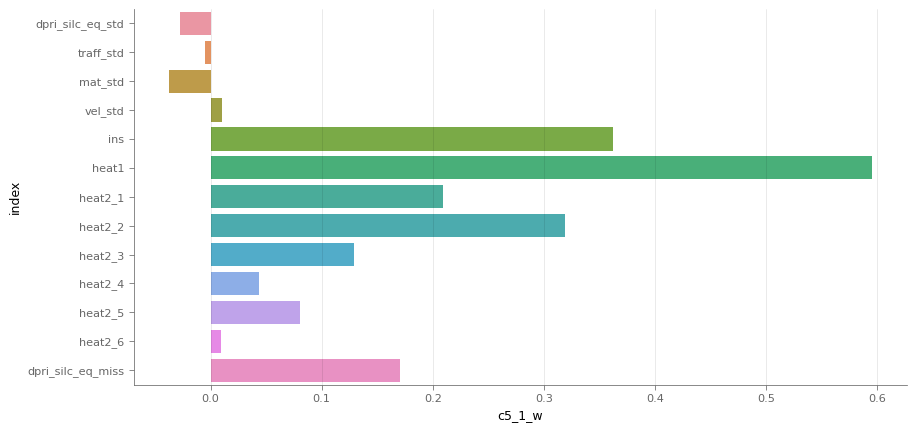

In [74]:
sns.barplot(data=foo, x='c5_1_w', y='index')

In [21]:
cl4, _ = pyreadstat.read_sav(f'{data_root}/lca4.sav')

In [22]:
cl4.head()

,heat1,heat2_1,heat2_2,heat2_3,heat2_4,heat2_5,heat2_6,ins,dpri_silc_eq_std,dpri_silc_eq_miss,traff_std,mat_std,vel_std,w,respid,clu#1,clu#2,clu#3,clu#4,clu#
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384795,0.0,-0.005053,-0.037638,0.379481,0.779386,1431.0,0.979301,2.069837e-02,5.129544e-09,1.229673e-07,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.495297,0.0,-1.040472,-0.037638,1.278793,1.577369,1439.0,0.982693,1.730712e-02,4.019092e-09,9.364675e-08,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.253512,0.0,0.685227,2.599656,-1.419142,0.896857,1445.0,0.000000,1.588352e-08,9.317189e-23,1.000000e+00,4.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.941225,0.0,-1.040472,-1.356284,-0.070175,1.426948,1497.0,0.000000,1.689799e-07,9.999951e-01,4.762183e-06,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745126,0.0,0.685227,-1.356284,-0.070175,0.641262,1505.0,0.000000,9.994315e-01,5.684920e-04,8.918027e-10,2.0


In [23]:
n = 4
cl4['respid'] = cl4['respid'].astype('int')
to_rename = {
    'clu#': f'c{n}_max',
    **{f'clu#{i}': f'c{n}_{i}' for i in range(1, n + 1)}
}
cl4 = cl4.rename(columns=to_rename)
cl4[f'c{n}_max'] = cl4[f'c{n}_max'].astype('int')
cl4 = cl4[['respid'] + [v for k, v in to_rename.items()]].copy()

In [24]:
cl4.head()

,respid,c4,c4_1,c4_2,c4_3,c4_4
0,1431,1,0.979301,2.069837e-02,5.129544e-09,1.229673e-07
1,1439,1,0.982693,1.730712e-02,4.019092e-09,9.364675e-08
2,1445,4,0.000000,1.588352e-08,9.317189e-23,1.000000e+00
3,1497,3,0.000000,1.689799e-07,9.999951e-01,4.762183e-06
4,1505,2,0.000000,9.994315e-01,5.684920e-04,8.918027e-10


In [10]:
contvars = ['dpri_silc_eq']
ordvars = ['traff', 'mat', 'vel']
binvars = ['ins', 'heat1'] + [f'heat2_{i}' for i in range(1, 7)]

<AxesSubplot:xlabel='w', ylabel='Count'>

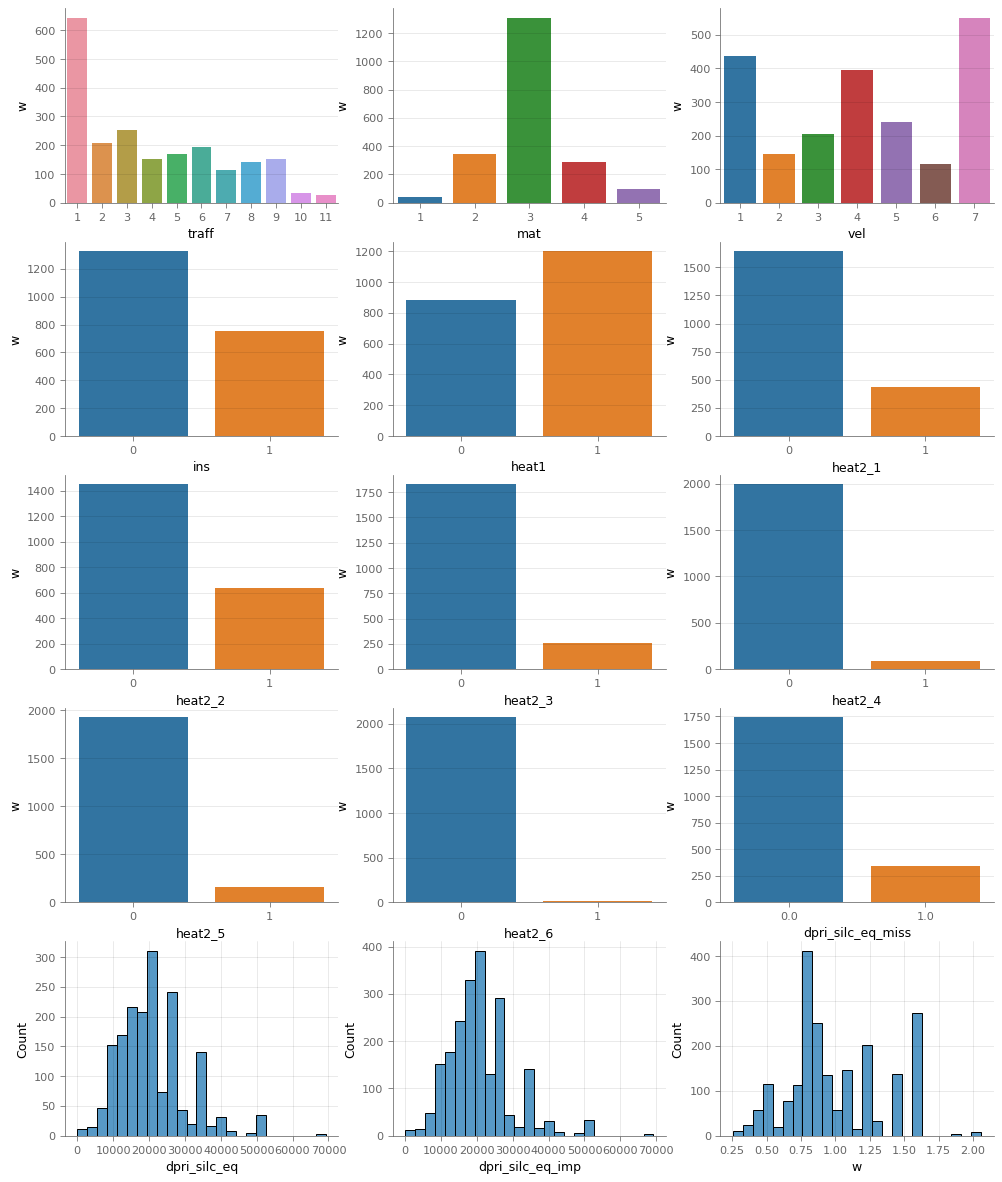

In [11]:
fig, ax = plt.subplots(5, 3, figsize=(12, 15))
noncontvars = ordvars + binvars + ['dpri_silc_eq_miss']

for i, x in enumerate(noncontvars):
    foo = df.groupby(x)['w'].sum().reset_index()
    sns.barplot(data=foo, x=x, y='w', ax=ax[i // 3][i % 3])

sns.histplot(data=df, x='dpri_silc_eq', weights='w', ax=ax[4][0], bins=25)
sns.histplot(data=df, x='dpri_silc_eq_imp', weights='w', ax=ax[4][1], bins=25)
sns.histplot(data=df, x='w', ax=ax[4][2], bins=25)

## LCA Fitting

In [12]:
plt.rcParams['figure.subplot.top'] = 0.92

def plot_lca(res, variables):
    sel = []
    
    foo = pd.DataFrame({'n': res['LL'].keys(), 'll': res['LL'].values(), 'aic': res['AIC'].values(), 'bic': res['BIC'].values()})

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    for i, x in enumerate(['ll', 'aic', 'bic']):
        sns.barplot(data=foo, x='n', y=x, ax=ax[i])
    sel.append(Chart(fig, title='Criteria'))

    nvars = len(variables)
    
    for n in range(2, 10):

        nrows = (n - 1) // 2 + 1
        fig, ax = plt.subplots(nrows, 2, figsize=(12, 1 + 3 * nrows))
        means = res['mean'][n][0]
        probs = res['prob'][n][0]

        for i in range(n):
            cur_means = means[i * nvars:(i + 1) * nvars]
            title = f'Cluster {i + 1} ({100 * probs[i]:.2f} %)'
            if n > 2:
                sns.barplot(x=cur_means, y=variables, ax=ax[i // 2, i % 2])
                ax[i // 2, i % 2].set_title(title)
            else:
                sns.barplot(x=cur_means, y=variables, ax=ax[i])
                ax[i].set_title(title)

        sel.append(Chart(fig, title=f'{n} clusters'))
        
    return sel

In [ ]:
%%time
res = {}
lls = {}
aics = {}
bics = {}
means = {}
probs = {}

for n in range(2, 10):
    logger(f'Fitting {n} clusters.')
    stata.run(f'gsem ($contordstds <- _cons) ($binvars <-, logit) [pw=w], lclass(C {n}) nonrtolerance', quietly=True)
    er = stata.get_ereturn()
    lls[n] = er['e(ll)']
    stata.run(f'predict c{n}_*, classposteriorpr')
    stata.run('estat lcgof', quietly=True)
    rr = stata.get_return()
    aics[n] = rr['r(aic)']
    bics[n] = rr['r(bic)']
    stata.run('estat lcmean, nose', quietly=True)
    rr = stata.get_return()
    means[n] = rr['r(b)']
    stata.run('estat lcprob, nose', quietly=True)
    rr = stata.get_return()
    probs[n] = rr['r(b)']    
    logger(f'{n} clusters: LL = {lls[n]:.1f}, AIC = {aics[n]:.1f}, BIC = {bics[n]:.1f}')
    
logger('Finished.')

res['LL'] = lls
res['AIC'] = aics
res['BIC'] = bics
res['mean'] = means
res['prob'] = probs

20:15:53.4 -- Fitting 2 clusters.
20:16:16.5 -- 2 clusters: LL = -18323.4, AIC = 36696.8, BIC = 36837.9
20:16:16.5 -- Fitting 3 clusters.
20:16:42.7 -- 3 clusters: LL = -17915.0, AIC = 35905.9, BIC = 36120.3
20:16:42.7 -- Fitting 4 clusters.


In [35]:
lca_sel = Selector(plot_lca(res, binvars + ['dpri_silc_eq_miss'] + contvars + ordvars), title='Classes')
lca_sel.save('output/lca2/res01')

In [13]:
binvars

['ins',
 'heat1',
 'heat2_1',
 'heat2_2',
 'heat2_3',
 'heat2_4',
 'heat2_5',
 'heat2_6']

In [29]:
cl2, cl2_meta = pyreadstat.read_sav('/mnt/d/projects/jan-krajhanzl/2022-06-19_segmentace-energeticka-chudoba/2cl.sav', encoding='cp1250')

In [30]:
cl2

,dpri_silc_eq_std,traff_std,mat_std,vel_std,heat1,heat2_1,heat2_2,heat2_3,heat2_4,heat2_5,heat2_6,w,respid,clu#1,clu#2,clu#
0,0.384795,-0.005053,-0.037638,0.379481,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779386,1431.0,0.000034,9.999656e-01,2.0
1,0.495297,-1.040472,-0.037638,1.278793,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.577369,1439.0,0.000013,9.999868e-01,2.0
2,-1.253512,0.685227,2.599656,-1.419142,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.896857,1445.0,1.000000,2.882325e-08,1.0
3,-0.941225,-1.040472,-1.356284,-0.070175,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.426948,1497.0,1.000000,2.659737e-07,1.0
4,0.745126,0.685227,-1.356284,-0.070175,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.641262,1505.0,0.000068,9.999321e-01,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,0.495297,0.340087,-1.356284,-0.969486,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.086609,2023.0,1.000000,1.260696e-11,1.0
2082,-0.701805,0.685227,-0.037638,1.278793,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557044,2026.0,0.000022,9.999778e-01,2.0
2083,-0.941225,-0.350193,-0.037638,-0.519830,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.705062,2052.0,1.000000,1.814805e-07,1.0
2084,-0.731539,-1.040472,-0.037638,-0.519830,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.902819,2055.0,0.000098,9.999021e-01,2.0


In [45]:
import math
math.sqrt(2 / math.pi)

0.7978845608028654

In [46]:
1.6 * 0.15

0.24